In [8]:
import os
import sys
from importlib import reload
module_paths = [
    os.path.abspath(os.path.join('..')),
]
for module_path in module_paths:
    if module_path not in sys.path:
        sys.path.append(module_path)
        
import torch
from time import time 
import csv

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.model_selection import train_test_split

import aav
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 14

import seaborn as sns
sns.set_style('darkgrid')

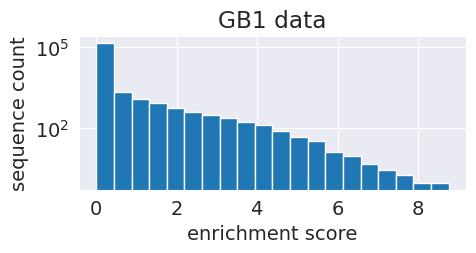

In [11]:
# data from
# https://github.com/fhalab/MLDE/blob/main/code/validation/basic_test_data/Gb1Dataset.csv
df = pd.read_csv('../data/gb1.csv')
seq_n = list(df['Variants'])
y_n = df['Fitness'].to_numpy()

plt.figure(figsize=(5, 2))
plt.hist(y_n, bins=20, log=True);
plt.xlabel('enrichment score');
plt.ylabel('sequence count');
plt.title('GB1 data');

In [ ]:
# generate training and test data
idx = np.random.choice(len(seq_n), 2000)
train_idx, test_idx = idx[: 1000], idx[1000 :]

trainseq_n = [seq_n[i] for i in train_idx]
ytrain_nx2 = y_nx2[train_idx]
testseq_n = [seq_n[i] for i in test_idx]
ytest_nx2 = y_nx2[test_idx]